[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iamthejao/DeepLearningLab-A1/blob/master/Assignment.ipynb)

In [114]:
# Importing libraries and checking for GPU support
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
sns.set_style('dark')
warnings.filterwarnings("ignore")

gpu_device = tf.test.gpu_device_name()
print("GPU: ",gpu_device)

GPU:  


In [0]:
# Function that receives a plot_dict defined by {"plot name":[x,y, typeOfPlot]} and plots.
def plot(plot_dict):
  
  fontdict = {'fontsize':14, 'weight':"bold"}
  labels = plot_dict.keys()
  
  fig = plt.figure(figsize=(19,9))
  for label in labels:
    if type(plot_dict[label]) in (list, np.ndarray):
      if type(plot_dict[label][0]) == list:
        x = plot_dict[label][0]
      else:
        x = plot_dict[label][0][:,1].flatten()
      y = plot_dict[label][1]
      type_ = plot_dict[label][2]

      if type_ == "scatter":
        plt.scatter(x,y, label=label)
      elif type_ == "plot":
        plt.plot(x,y, label=label)
      else:
        pass
      plt.hold(True)
    
  plt.legend(fontsize='medium')
  plt.title(plot_dict['Title'] , fontdict=fontdict)
  plt.xlabel(plot_dict['xlabel'], fontdict=fontdict)
  plt.ylabel(plot_dict['ylabel'], fontdict=fontdict)
  plt.grid(True)
  plt.show()

 Question 1)
 
 Create the dataset according to a generator polynome defined by its coefficient vector $W_*$ and the polynomial matrix $x$, where $p(X) = xW_*$.
The function **create_dataset** returns a dataset $d(x) = p(x) + error$ ~ $N(0, sigma)$ where $x$ are uniformly distributed random values inside the given range.

In [0]:
# Question 1, create dataset function.
# Create a dataset according to a generator polynome defined by w_star, where p(X) = x*w_star
# returns a dataset d(X) = p(X) + error ~ N(0,sigma)
def create_dataset(w_star, x_range, sample_size, sigma, seed=None):
  random_state = np.random.RandomState(seed)
  x = random_state.uniform(x_range[0] , x_range[1] , (sample_size))
  X = np.zeros((sample_size , w_star.shape[0]))
  for i in range(sample_size):
    X[i, 0] = 1.
    for j in range(1, w_star.shape[0]):
      X[i, j] = x[i]**j
  y = X.dot(w_star).flatten()
  if sigma > 0:
    y += random_state.normal(0.0 , sigma , sample_size )
  return X, y



Question 2) Defining training function and learning rate and iterations

In order to check the right number of iterations, two stop criterias were used.

1.   Minimum variation of training set loss between epochs.
2.   Difference between epochs between current and previous best validation loss (Validation loss should decrease, otherwise it is overfits the training set and should stop.)



In [0]:
# Defining the Tensorflow environment to calculate the problem
def gradient_descent_linearRegression(Xtrain, ytrain, learning_rate, iterations, session=None, validation=None, print_interval=50, loss_chg_criteria=1E-6, validation_chg_iter=10, printLoss=False):
  
  # Setting TF variables
  X = tf.placeholder(tf.float32, shape=(None, Xtrain.shape[-1]))
  y = tf.placeholder(tf.float32, shape=(None,))
  w = tf.Variable(tf.zeros((Xtrain.shape[-1],1), dtype=tf.float32), trainable=True)
  
  # Mounting loss function
  prediction = tf.reshape(tf.matmul(X, w), (-1,))
  loss = tf.reduce_mean(tf.square(y - prediction))
  
  # Selecting optimizer
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  train = optimizer.minimize(loss)
  
  # Creating session
  if session is None:
    session = tf.Session()
    
  initializer = tf.global_variables_initializer()
  session.run(initializer)
  
  # Iterating training
  last_loss = None
  best_validation_loss = None
  best_validation_epoch = None
  validation_loss = None
  training_loss_evolution = []
  validation_loss_evolution = []
  for i in range(iterations):
    l, _ = session.run([loss, train], feed_dict={X:Xtrain, y: ytrain})
    
    if validation is not None:
      validation_loss = session.run(loss, feed_dict={X:validation[0], y:validation[1]})
    
    # Appending to log
    training_loss_evolution.append(l)
    validation_loss_evolution.append(validation_loss)
    
    # Stop criteria (variation of training loss function) and validation iteration.
    
    if last_loss is None:
      last_loss = l
      best_validation_loss = validation_loss
      best_validation_epoch = i
    else:
      
      # Training loss variation criteria
      diff = abs(l-last_loss)
      if diff < loss_chg_criteria:
        print("Finished in {0} iterations due to stop criteria of {1} loss change in training set.".format(i+1, loss_chg_criteria))
        print("Loss: {0}".format(l))
        break 
      else:
        last_loss = l
      
      # Previous best variation loss criteria
      if validation is not None:
        if (validation_loss < best_validation_loss):
          best_validation_loss = validation_loss
          best_validation_epoch = i

        if (i - best_validation_epoch) >= validation_chg_iter:
          print("Loss: {0}".format(l))
          print("Finished in {0} iterations due to stop criteria of validation loss".format(i+1))
          break
        
    if (i+1) % print_interval == 0:
      print("Iteration {0}".format(i+1))
      print("Training loss: {0}, validation loss: {1}".format(l,validation_loss))
      print("Best validation loss so far: {0}".format(best_validation_loss))
      
  # Check if validation set is given
  if validation is not None:
    Xval, yval = validation
    l = session.run(loss, feed_dict={X:Xval, y:yval})
    print("Validation loss: {0}".format(l))
  
  # Plotting
  if (printLoss):
    plot_dict = {"Training loss":[list(range(len(training_loss_evolution))),training_loss_evolution,'plot']}
    plot_dict['Title'] = "Loss function evolution"
    plot_dict['xlabel'] = "Iterations"
    plot_dict['ylabel'] = "MSE"
    if validation:
      plot_dict["Validation loss"] = [list(range(len(validation_loss_evolution))),validation_loss_evolution,'plot']
    plot(plot_dict)
   
  return session.run(w)

The learning ratio was defined by testing the convergence of the function for different values. For high values the function diverges and for that reason, the learning rate was defined as 1%.


In [0]:
# Defining variables for first exercise
w_star = np.array([-8, -4, 2, 1])[np.newaxis].T
x_range = [-3,2]
sample_size = 100
seed_train = 0
seed_validation = 1
sigma = 0.5

# Question 2
# Higher learning rates will diverge for this sample. So it is set to 1% which is the guarantees convergence at an acceptable rate.
learning_rate = 0.01

In [0]:
# Creating train and validation dataset
X_train, y_train = create_dataset(w_star, x_range, sample_size, sigma, seed=seed_train)
X_val, y_val = create_dataset(w_star, x_range, sample_size, sigma, seed=seed_validation)

Iteration 200
Training loss: 2.6061182022094727, validation loss: 2.5305962562561035
Best validation loss so far: 2.5305962562561035
Iteration 400
Training loss: 0.5028912425041199, validation loss: 0.47624215483665466
Best validation loss so far: 0.47624215483665466
Iteration 600
Training loss: 0.2720271050930023, validation loss: 0.24607497453689575
Best validation loss so far: 0.24607497453689575
Iteration 800
Training loss: 0.24608522653579712, validation loss: 0.22056415677070618
Best validation loss so far: 0.22056415677070618
Iteration 1000
Training loss: 0.2431589961051941, validation loss: 0.21791847050189972
Best validation loss so far: 0.21791847050189972
Finished in 1123 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 0.2428840696811676
Validation loss: 0.21772891283035278


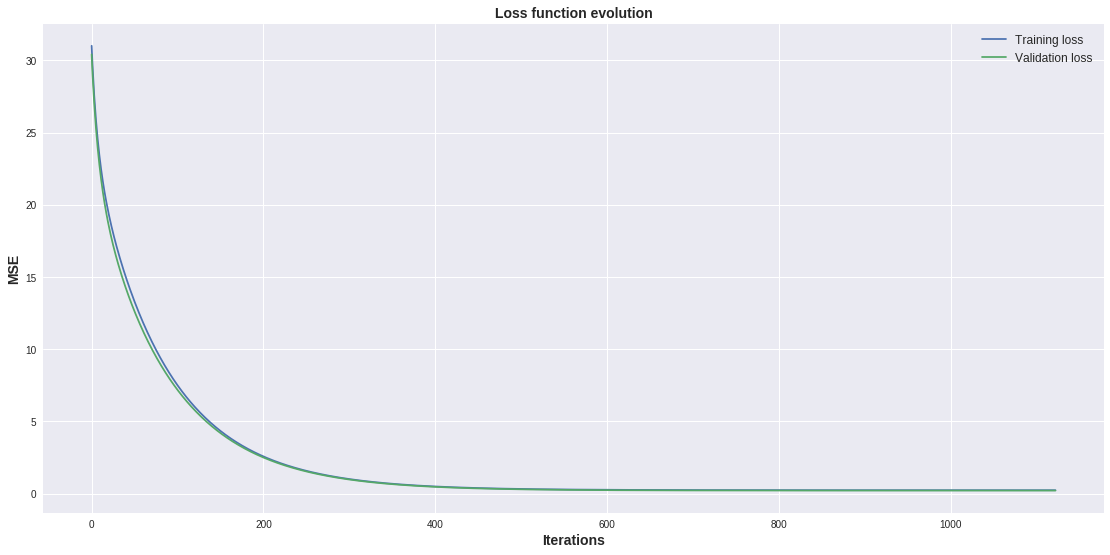

In [157]:
w_train = gradient_descent_linearRegression(X_train, y_train, learning_rate, 2000, validation=(X_val,y_val), print_interval=200, loss_chg_criteria=1E-6, validation_chg_iter=10, printLoss=True)

Question 3)
We create a fine grid for the plot and then calculate the true polynome value and training result in this grid.

In [0]:
# Question 3
# Creating plot space for X
plot_size = 1000
x_plot = np.linspace(x_range[0], x_range[1], plot_size)
X_plot = np.ones((plot_size,1))
for i in range(1,w_star.shape[0]):
  X_plot = np.hstack((X_plot, (x_plot ** i)[np.newaxis].T))

y_trained = X_plot.dot(w_train).flatten()
y_generation = X_plot.dot(w_star).flatten()


In [0]:
plot_dict = {"Train dataset":[X_train, y_train, "scatter"],
             "$x^{3} + 2x^{2}-4x-8$":[X_plot, y_generation, "plot"],
             "Regression Train (size=100, $\sigma$=0.5)":[X_plot, y_trained, "plot"],
            "Title":"Polynomial regression dataset comparison",
            "xlabel":"X",
            "ylabel":"$p(X)=xW$"}

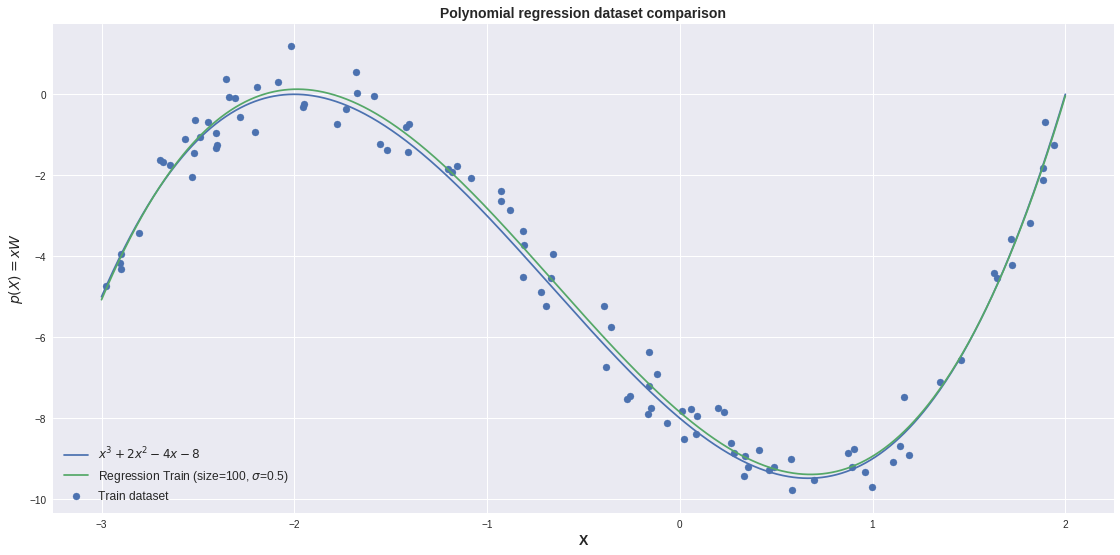

In [161]:
plot(plot_dict)

Question 4)

In [172]:
# Question 4
# Training for different sample sizes
sample_sizes = [5, 10, 50, 100]
wsamples = []
for s in sample_sizes:
  print("Sample size: ",s)
  w_s = gradient_descent_linearRegression(X_train[0:s], y_train[0:s], learning_rate, 2000, validation=(X_val[0:s],y_val[0:s]), print_interval=2000, validation_chg_iter=25)
  print("")
  wsamples.append(w_s)

Sample size:  5
Loss: 5.469444274902344
Finished in 83 iterations due to stop criteria of validation loss
Validation loss: 21.87615394592285

Sample size:  10
Loss: 11.616852760314941
Finished in 51 iterations due to stop criteria of validation loss
Validation loss: 19.69131851196289

Sample size:  50
Finished in 1104 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 0.255158931016922
Validation loss: 0.1938394010066986

Sample size:  100
Finished in 1123 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 0.2428840696811676
Validation loss: 0.21772891283035278



In Question 4, it is possible to notice the difference between validation error and loss error. It is clear that the first two cases, sample size 5 and 10, the validation error is much higher than the training error, indicating an underfit scenario (the validation loss stop criteria was increased to check this effect). As we increase the number of samples and consequently the coverage of the space in the training set, the training and validation error approximate.

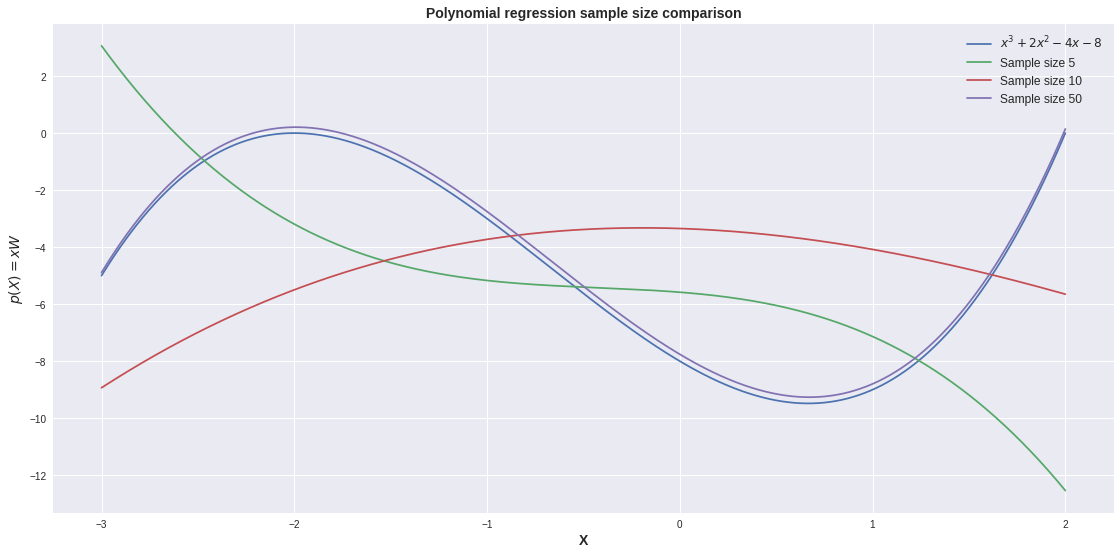

In [173]:
plot_dict = {"$x^{3} + 2x^{2}-4x-8$":[X_plot, y_generation, "plot"],
             "Sample size 5":[X_plot, X_plot.dot(wsamples[0]).flatten(), "plot"],
             "Sample size 10":[X_plot, X_plot.dot(wsamples[1]).flatten(), "plot"],
             "Sample size 50":[X_plot, X_plot.dot(wsamples[2]).flatten(), "plot"],
              "Title":"Polynomial regression sample size comparison",
              "xlabel":"X",
              "ylabel":"$p(X)=xW$"}
plot(plot_dict)

Question 5

In [149]:
# Question 5
# Training for different sigmas
sigmas = [2, 4, 8]
wsigmas = []
for s in sigmas:
  X_sigma_train, y_sigma_train = create_dataset(w_star, x_range, sample_size, s, seed=seed_train)
  X_sigma_val, y_sigma_val = create_dataset(w_star, x_range, sample_size, s, seed=seed_validation)
  print("Sigma: ", s)
  w_sig = gradient_descent_linearRegression(X_sigma_train, y_sigma_train, 0.01, 2000, validation=(X_sigma_val, y_sigma_val), print_interval=2000, validation_chg_iter=25)
  print("")
  wsigmas.append(w_sig)

Sigma:  2
Finished in 1078 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 3.8847413063049316
Validation loss: 3.4833364486694336

Sigma:  4
Finished in 1002 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 15.538686752319336
Validation loss: 13.93358039855957

Sigma:  8
Finished in 920 iterations due to stop criteria of 1e-06 loss change in training set.
Loss: 62.15415573120117
Validation loss: 55.73496627807617



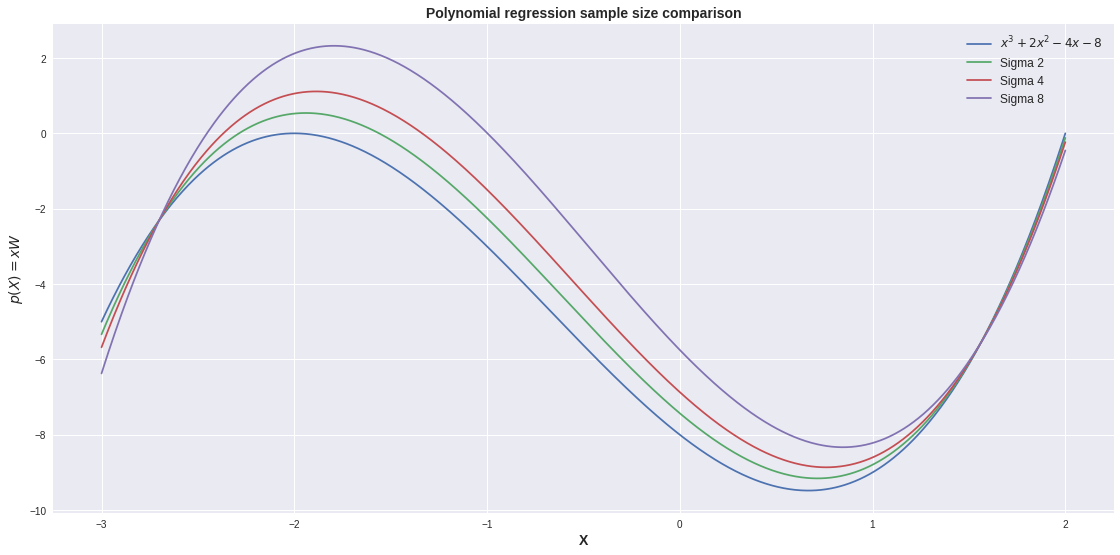

In [150]:
plot_dict = {"$x^{3} + 2x^{2}-4x-8$":[X_plot, y_generation, "plot"],
             "Sigma 2":[X_plot, X_plot.dot(wsigmas[0]).flatten(), "plot"],
             "Sigma 4":[X_plot, X_plot.dot(wsigmas[1]).flatten(), "plot"],
             "Sigma 8":[X_plot, X_plot.dot(wsigmas[2]).flatten(), "plot"],
              "Title":"Polynomial regression noise comparison",
              "xlabel":"X",
              "ylabel":"$p(X)=xW$"}
plot(plot_dict)